For the analysis that we had created before, Ricardo and I had noticed that there were some discrepancies in the generation of the descriptive statistics. 

The calculations were being performed properly, however, the dataset that we were using was spread out over too large of an area (Bueno Aires is an area of 200 km$^2$, whereas Sydney's Urban Centre Locality was 3,483 km$^2$. We decided to do the following: 

1. Create a new dataframe that aggregates the data by the hex-ID
2. Perform a spatial join with the newly generated groupby dataframe and then aggregate the statistics from that 
3. Comparing the absolute values of tweets within a hexagon between two periods instead of the percentage change
4. Aggregate the data in two periods, but instead of taking the average of both periods, count the total number of tweets in each period
    * Consider dropping a period of data because of the missing data in 2015. 
5. Cut the lat/lon for the Sydney.plot('')


In [27]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3
import datetime
import matplotlib.pyplot as plt

In [28]:
import importlib
importlib.reload(databasepopulation)
importlib.reload(home)
importlib.reload(a)
importlib.reload(myh3)

<module 'my_h3_functions' from '..\\my_h3_functions.py'>

# 0. Connect to Mongo and define a specific database

In [3]:
db=commu.connecttoLocaldb(database='twitter_hk')

# 1. Obtaining hexcounts from database

In [4]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

1.586662769317627


In [5]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,8941022db2fffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89410329417ffff,1372550400000,2.0,2.0,NaN,2.0,2013-06-30
2,8941032d043ffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
3,8941032d04bffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
4,8941032d207ffff,1419984000000,1.0,1.0,NaN,1.0,2014-12-31


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121763 entries, 0 to 121762
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          121763 non-null  object        
 1   level_1                      121763 non-null  object        
 2   nonresidents                 121200 non-null  float64       
 3   nonresidentsandnonneighbors  120532 non-null  float64       
 4   residents                    17203 non-null   float64       
 5   totalcounts                  121763 non-null  float64       
 6   time                         121763 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 7.4+ MB


In [7]:
# create a groupby on the time so that we can know which time frames to remove from both periods of analysis 
df.groupby('time').sum()

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
time,,,,
2012-09-30,172292.0,155750.0,17125.0,189417.0
2012-12-31,276532.0,246765.0,33407.0,309939.0
2013-03-31,245292.0,214706.0,33071.0,278363.0
2013-06-30,272231.0,241616.0,34509.0,306740.0
2013-09-30,171118.0,152781.0,18343.0,189461.0
2013-12-31,105025.0,93568.0,10449.0,115474.0
2014-03-31,191828.0,170508.0,20926.0,212754.0
2014-06-30,280943.0,251866.0,31508.0,312451.0
2014-09-30,283366.0,247063.0,41589.0,324955.0


Technically, if we were to just count time periods, five quarter (trimestres) after our second observation period is `2015-12-31`, so the equivalent of that from the first time period is `2013-09-30`. I'm going to remove all observations from that time. 

In [8]:
# create variable that is the dt value for our observation period
datebeforeandafterperiod=datetime.datetime(2014,9,30)
# create a dummy variable based on dt value above
df['period']=np.where(df.time>datebeforeandafterperiod,1,0)

In [9]:
df2=df.groupby(['_id','period']).mean()
df2.reset_index(inplace=True)

In [10]:
df2

,_id,period,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
0,8941022db2fffff,0,1.0,1.0,NaN,1.0
1,89410329417ffff,0,2.0,2.0,NaN,2.0
2,8941032d043ffff,0,1.0,1.0,NaN,1.0
3,8941032d04bffff,0,1.0,1.0,NaN,1.0
4,8941032d207ffff,1,1.0,1.0,NaN,1.0
...,...,...,...,...,...,...
21836,89411dd8d3bffff,1,1.0,1.0,NaN,1.0
21837,89411dd94dbffff,0,1.0,1.0,NaN,1.0
21838,89411dd9927ffff,0,1.0,1.0,NaN,1.0
21839,89411dd99afffff,0,6.0,6.0,NaN,6.0


## 2. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [11]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

# read the new file 
tracts = gpd.read_file(shp_path/"hk.geojson")
# print
tracts = tracts.to_crs('EPSG:4326')

In [13]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   OBJECTID            5034 non-null   int64   
 1   PPU                 5034 non-null   int64   
 2   SPU                 5034 non-null   int64   
 3   TPU                 5034 non-null   int64   
 4   SB_VC               5034 non-null   int64   
 5   TYPE_Eng            5034 non-null   object  
 6   TYPE_TC             5034 non-null   object  
 7   TYPE_SC             5034 non-null   object  
 8   Shape_Length        5034 non-null   float64 
 9   Shape_Area          5034 non-null   float64 
 10  category            5034 non-null   int64   
 11  label               5034 non-null   object  
 12  standardized_types  5034 non-null   object  
 13  geometry            5034 non-null   geometry
dtypes: float64(2), geometry(1), int64(6), object(5)
memory usage: 550.7+ KB


In [14]:
tracts.Shape_Area.sum()

1109866881.5433416

In [15]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   OBJECTID            5034 non-null   int64   
 1   PPU                 5034 non-null   int64   
 2   SPU                 5034 non-null   int64   
 3   TPU                 5034 non-null   int64   
 4   SB_VC               5034 non-null   int64   
 5   TYPE_Eng            5034 non-null   object  
 6   TYPE_TC             5034 non-null   object  
 7   TYPE_SC             5034 non-null   object  
 8   Shape_Length        5034 non-null   float64 
 9   Shape_Area          5034 non-null   float64 
 10  category            5034 non-null   int64   
 11  label               5034 non-null   object  
 12  standardized_types  5034 non-null   object  
 13  geometry            5034 non-null   geometry
dtypes: float64(2), geometry(1), int64(6), object(5)
memory usage: 550.7+ KB


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

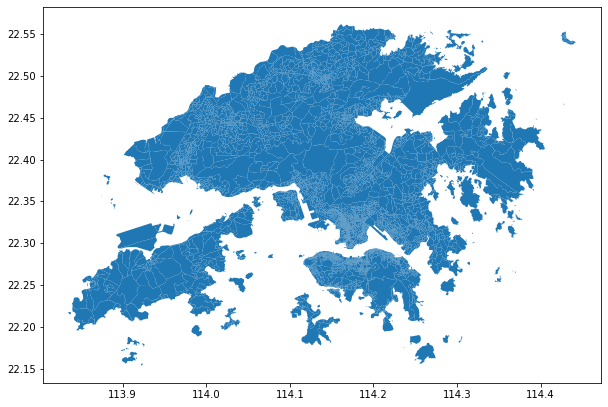

In [16]:
tracts.plot()

tracts.crs

In [17]:
# Create a geodataframe out of the grouped hex dataframe `df2`
gdf = myh3.df_with_hexid_to_gdf(df2, hexcolname='_id')

In [18]:
# Create a dataframe agg_gdf out of the tracts above and the geodataframe we created before 
agg_gdf = gpd.sjoin(gdf,tracts,how='inner',op='intersects')

In [19]:
# Generate a quick pivot table to see the different sums of each of the variables between the different periods
agg_gdf.pivot_table(index='standardized_types', 
                    columns='period', 
                    aggfunc={'nonresidents':sum,
                             'nonresidentsandnonneighbors':sum,
                             'residents':sum,
                             'totalcounts':sum,}, 
                    fill_value=0)

nonresidents                 \
period                                     0              1   
standardized_types                                            
Exclusive Static               252823.638095  156405.797619   
Low Income, At Risk of Change  297425.489683  165019.717460   
Low Income, Stable             526975.735714  364750.809921   
Low Income, Undergoing Change   65857.171032   24516.247222   
Other                          697198.536111  573102.389683   

                              nonresidentsandnonneighbors                 \
period                                                  0              1   
standardized_types                                                         
Exclusive Static                            233307.709524  144771.806349   
Low Income, At Risk of Change               270694.707143  153696.026190   
Low Income, Stable                          473087.432540  339748.184921   
Low Income, Undergoing Change                56236.083730   22842.382540   
Other                                       601367.585714  534085.458730   

                                   residents                  totalcounts  \
period                                     0             1              0   
standardized_types                                                          
Exclusive Static                23355.418254  16635.008730  272162.032937   
Low Income, At Risk of Change   36284.207540  19039.984127  328264.176190   
Low Income, Stable              64168.021825  50356.442857  575687.637302   
Low Income, Undergoing Change    6674.759921   4705.124603   70203.523810   
Other                          128539.774603  76759.855952  804805.812302   

                                              
period                                     1  
standardized_types                            
Exclusive Static               169763.427381  
Low Income, At Risk of Change  176734.971032  
Low Income, Stable             398415.163889  
Low Income, Undergoing Change   27190.933333  
Other                          625554.651587

In [20]:
agg_gdf.pivot_table(index='standardized_types', 
                    columns='period', 
                    aggfunc={'nonresidents':np.median,
                             'nonresidentsandnonneighbors':np.median,
                             'residents':np.median,
                             'totalcounts':np.median,}, 
                    fill_value=0)

nonresidents            \
period                                   0         1   
standardized_types                                     
Exclusive Static                  3.555556  2.500000   
Low Income, At Risk of Change    23.333333  9.875000   
Low Income, Stable                5.666667  3.625000   
Low Income, Undergoing Change     4.111111  2.555556   
Other                            14.777778  7.750000   

                              nonresidentsandnonneighbors            \
period                                                  0         1   
standardized_types                                                    
Exclusive Static                                 3.500000  2.500000   
Low Income, At Risk of Change                   20.000000  8.888889   
Low Income, Stable                               5.222222  3.250000   
Low Income, Undergoing Change                    4.111111  2.555556   
Other                                           11.777778  6.833333   

                               residents           totalcounts             
period                                 0         1           0          1  
standardized_types                                                         
Exclusive Static               14.571429  9.000000    3.875000   2.750000  
Low Income, At Risk of Change  10.000000  6.000000   26.000000  11.222222  
Low Income, Stable              9.250000  6.000000    6.555556   4.000000  
Low Income, Undergoing Change   7.611111  7.666667    4.333333   2.555556  
Other                          13.625000  7.333333   17.444444   8.625000

In [21]:
agg_group = agg_gdf[['nonresidents',
         'nonresidentsandnonneighbors',
                     'residents','totalcounts',
         'standardized_types','period']].groupby(['standardized_types','period']).agg(['mean',
                                            'median',
                                            'count',
                                            'sem'])
agg_group

nonresidents                              \
                                             mean     median count        sem   
standardized_types            period                                            
Exclusive Static              0        118.529601   3.555556  2133  11.273550   
                              1         80.663124   2.500000  1939   6.498964   
Low Income, At Risk of Change 0        116.318142  23.333333  2557   6.507141   
                              1         68.246368   9.875000  2418   4.017346   
Low Income, Stable            0         76.484142   5.666667  6890   3.866269   
                              1         56.682333   3.625000  6435   8.535959   
Low Income, Undergoing Change 0         61.491289   4.111111  1071   4.333700   
                              1         25.326702   2.555556   968   2.266311   
Other                         0        101.989253  14.777778  6836   2.996094   
                              1         89.729511   7.750000  6387  11.963013   

                                     nonresidentsandnonneighbors             \
                                                            mean     median   
standardized_types            period                                          
Exclusive Static              0                       109.431383   3.500000   
                              1                        74.856156   2.500000   
Low Income, At Risk of Change 0                       105.988531  20.000000   
                              1                        63.800758   8.888889   
Low Income, Stable            0                        68.782703   5.222222   
                              1                        52.862640   3.250000   
Low Income, Undergoing Change 0                        52.508015   4.111111   
                              1                        23.597503   2.555556   
Other                         0                        88.009306  11.777778   
                              1                        84.015331   6.833333   

                                                       residents             \
                                     count        sem       mean     median   
standardized_types            period                                          
Exclusive Static              0       2132  10.846706  30.975356  14.571429   
                              1       1934   6.039456  25.911229   9.000000   
Low Income, At Risk of Change 0       2554   6.221601  26.141360  10.000000   
                              1       2409   3.773520  16.599812   6.000000   
Low Income, Stable            0       6878   3.683565  22.860001   9.250000   
                              1       6427   8.509718  23.809193   6.000000   
Low Income, Undergoing Change 0       1071   3.808694  15.239178   7.611111   
                              1        968   2.197260  14.657709   7.666667   
Other                         0       6833   2.746833  36.300416  13.625000   
                              1       6357  11.997164  27.375127   7.333333   

                                                     totalcounts             \
                                     count       sem        mean     median   
standardized_types            period                                          
Exclusive Static              0        754  1.411122  127.357058   3.875000   
                              1        642  1.572079   87.371810   2.750000   
Low Income, At Risk of Change 0       1388  1.308563  128.378638  26.000000   
                              1       1147  1.022877   73.091386  11.222222   
Low Income, Stable            0       2807  0.892470   83.432991   6.555556   
                              1       2115  1.618337   61.798536   4.000000   
Low Income, Undergoing Change 0        438  1.557296   65.549509   4.333333   
                              1        321  1.913006   28.060819   2.555556   
Other                         0       3541  1.169014  117.

In [22]:
agg_group.reset_index(inplace=True)

## Total Tweets by Typology Calculations (Ricardo 2.3)

In [53]:
stats1=agg_gdf[['nonresidents', 'nonresidentsandnonneighbors', 
                'residents', 'totalcounts', 
                'standardized_types','period']].groupby('standardized_types').agg([ 'sum'])

stats1.reset_index(inplace=True)
stats1=stats1.sort_values(by=('totalcounts','sum'), ascending=False)

stats1=stats1.loc[stats1.standardized_types!='Other']
stats1

,standardized_types,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,period
,,sum,sum,sum,sum,sum
2,"Low Income, Stable",891726.545635,812835.617460,114524.464683,974102.801190,6447
1,"Low Income, At Risk of Change",462445.207143,424390.733333,55324.191667,504999.147222,2418
0,Exclusive Static,409229.435714,378079.515873,39990.426984,441925.460317,1943
3,"Low Income, Undergoing Change",90373.418254,79078.466270,11379.884524,97394.457143,969


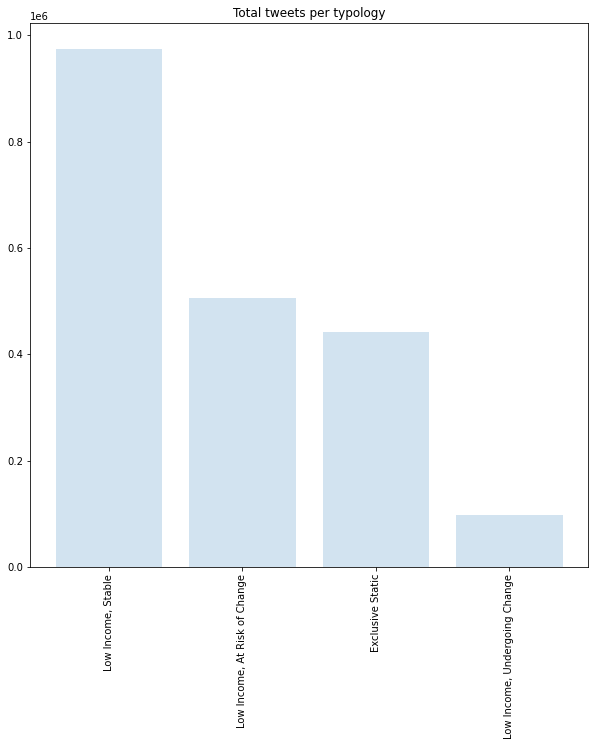

In [54]:
fig, ax = plt.subplots()
ax.bar(stats1['standardized_types'], stats1['totalcounts','sum'], alpha=0.2)
plt.title('Total tweets per typology')
plt.xticks(rotation=90) 
plt.show()

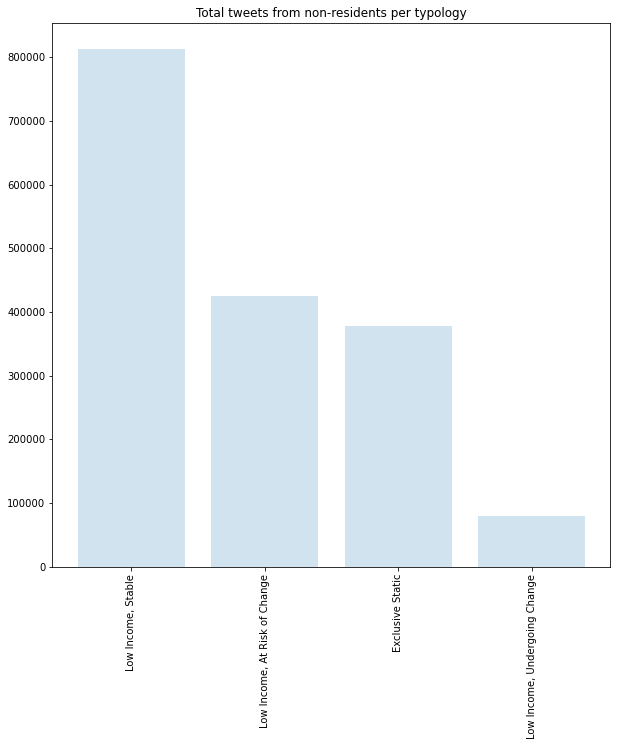

In [55]:
fig, ax = plt.subplots()
plt.title('Total tweets from non-residents per typology')
ax.bar(stats1['standardized_types'], stats1['nonresidentsandnonneighbors','sum'], alpha=0.2)
plt.xticks(rotation=90) 
plt.show()

## 2.4 Hex-level statistics of the total number of tweets (complete period)

In [57]:
stats2=agg_gdf[['nonresidents', 'nonresidentsandnonneighbors', 
                'residents', 'totalcounts', 'standardized_types']
              ].groupby('standardized_types').agg(['mean','sem', 'median', 'count'])

stats2.reset_index(inplace=True)

stats2=stats2.sort_values(by=('nonresidentsandnonneighbors','mean'), ascending=False)

#removing categories from graph
stats2=stats2.loc[stats2.standardized_types!='Other']
stats2

standardized_types nonresidents                              \
                                         mean       sem     median  count   
0               Exclusive Static   100.498388  6.672879   3.000000   4072   
1  Low Income, At Risk of Change    92.953810  3.887298  14.444444   4975   
2             Low Income, Stable    66.921317  4.582049   4.555556  13325   
3  Low Income, Undergoing Change    44.322422  2.548778   3.444444   2039   

  nonresidentsandnonneighbors                              residents  \
                         mean       sem     median  count       mean   
0                   92.985616  6.376776   2.800000   4066  28.646438   
1                   85.510928  3.700353  12.500000   4963  21.824139   
2                   61.092493  4.530614   4.125000  13305  23.267872   
3                   38.782965  2.278203   3.444444   2039  14.993260   

                             totalcounts                              
        sem     median count        mean       sem     median  count  
0  1.052314  11.000000  1396  108.315064  6.893343   3.250000   4080  
1  0.858008   9.000000  2535  101.507366  4.116367  17.000000   4975  
2  0.861694   7.555556  4922   72.982903  4.739853   5.000000  13347  
3  1.208447   7.666667   759   47.742381  2.645292   3.633333   2040

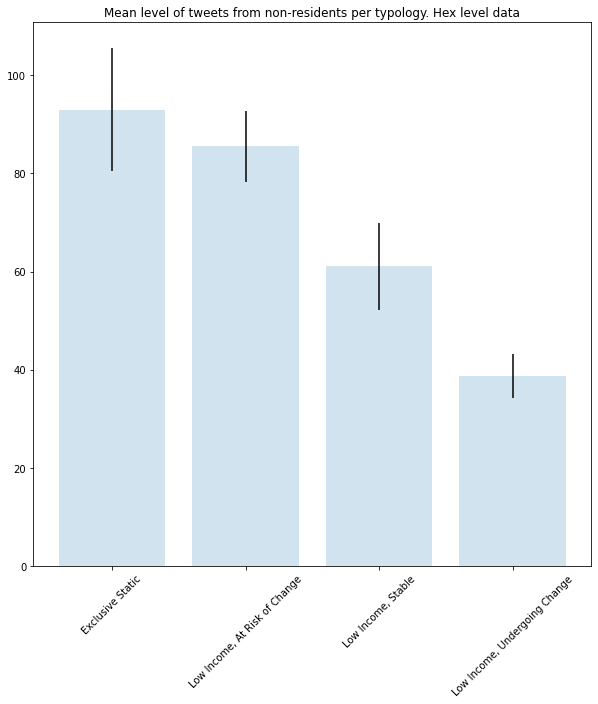

In [58]:
fig, ax = plt.subplots()
plt.title('Mean level of tweets from non-residents per typology. Hex level data')

ax.bar(stats2['standardized_types'], stats2['nonresidentsandnonneighbors','mean'], 
       yerr=1.96*stats2['nonresidentsandnonneighbors','sem'], alpha=0.2)

plt.xticks(rotation=45) 
plt.show()

## 3. Statistics splitting the sample in two time periods and computing time changes (i.e., before-after)

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. The result is also a GeoDataFrame ready to plot

### 2.1 Compute changes

Note: changes can be computed by first averaging the quarter level data of each period, or alternatively, by summing the data in each period. We will start by averaging which is the default option in a.percent_change_two_periods function

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121763 entries, 0 to 121762
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          121763 non-null  object        
 1   level_1                      121763 non-null  object        
 2   nonresidents                 121200 non-null  float64       
 3   nonresidentsandnonneighbors  120532 non-null  float64       
 4   residents                    17203 non-null   float64       
 5   totalcounts                  121763 non-null  float64       
 6   time                         121763 non-null  datetime64[ns]
 7   period                       121763 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), object(2)
memory usage: 7.9+ MB


In [60]:
# 2 Define a midpoint date to separate the two periods in the data. Remember here to change the datetime to the midpoint date in the previous step.
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2014,9,30))

In [61]:
gdfchanges.head(3)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,8941032d22bffff,0.857143,0.857143,NaN,0.857143,0.142857,0.142857,NaN,0.142857,6.0,6.0,NaN,6.0,NaN,NaN,NaN,NaN,"POLYGON ((113.38313 22.02149, 113.38274 22.023..."
1,8941032d23bffff,3.750000,3.750000,NaN,3.750000,0.250000,0.250000,NaN,0.250000,15.0,15.0,NaN,15.0,NaN,NaN,NaN,NaN,"POLYGON ((113.38535 22.01901, 113.38495 22.020..."
2,894103450c7ffff,-0.500000,-0.500000,NaN,-0.500000,1.000000,1.000000,NaN,1.000000,-0.5,-0.5,NaN,-0.5,NaN,NaN,NaN,NaN,"POLYGON ((114.02590 22.08263, 114.02552 22.084..."


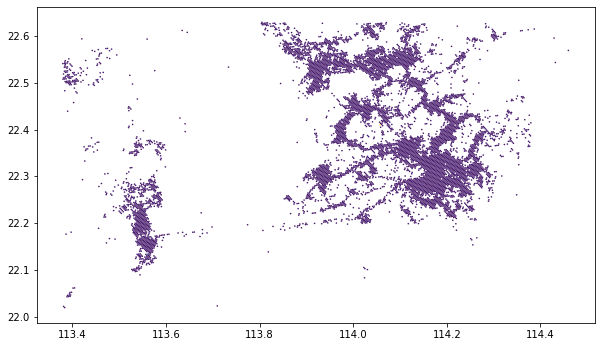

In [62]:
# Plot example
gdfchanges.plot('nonresidents_dif')

### 2.2. Spatial join with census tracks (typologies) data

This requires:

    1. An available function changes the geometry of the gdf to the centroids
    2. Load your typologies data to a geodataframe
    3. Spatial join



In [63]:
#1 Get centroids
gdfchanges_points=myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

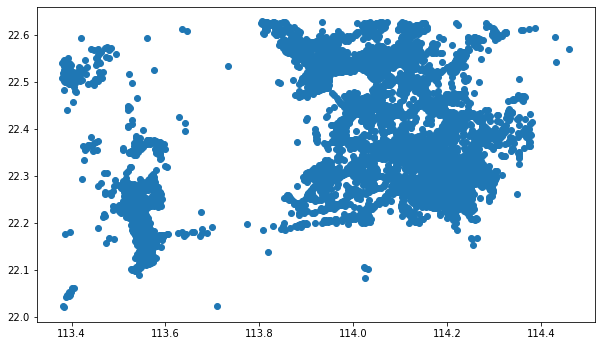

In [64]:
gdfchanges_points.plot()

In [65]:
# 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [66]:
typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 
                          'nonresidents_p0', 'standardized_types']
                        ].groupby('standardized_types').agg(['mean','count','sem'])

typo_stats.reset_index(inplace=True)

In [67]:
typo_stats

standardized_types nonresidents_dif                   \
                                             mean count        sem   
0               Exclusive Static       -18.648126   440   9.265573   
1  Low Income, At Risk of Change       -31.328005   398  10.424849   
2             Low Income, Stable       -18.433719  1477   3.276807   
3  Low Income, Undergoing Change        -8.606660   216   6.923166   
4                          Other        22.069601  1242  39.771776   

  nonresidents_ch                 nonresidents_p0                   
             mean count       sem            mean count        sem  
0        1.309016   440  0.650421       47.248112   442  14.666666  
1        0.027170   398  0.089032       63.745020   398  12.986840  
2        0.839111  1477  0.290494       47.607264  1480   5.522441  
3        0.209410   216  0.108716       31.636558   216   8.045224  
4        0.547251  1242  0.186007       48.585065  1243   4.767627

In [68]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='Other']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

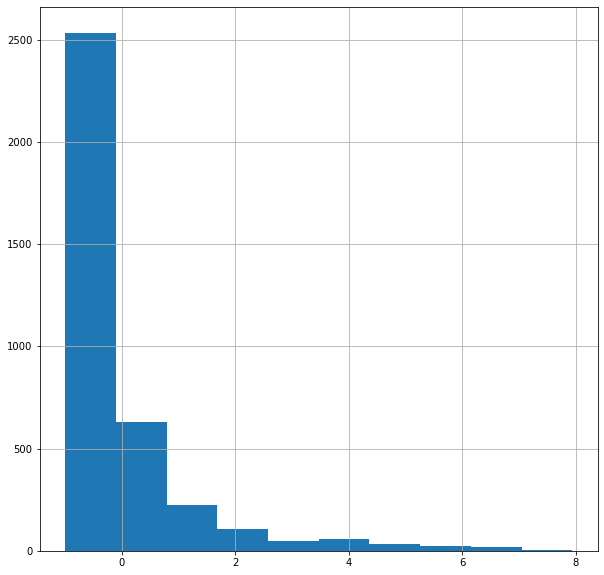

In [69]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

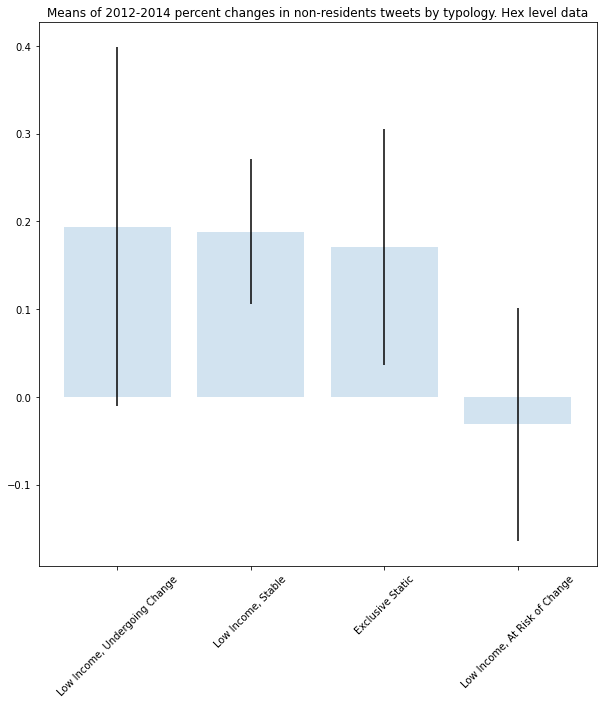

In [70]:
barchart(tweets_tracts, 'nonresidents_ch', 
         title='Means of 2012-2014 percent changes in non-residents tweets by typology. Hex level data')

## Repeat analysis summing tweets in each period

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


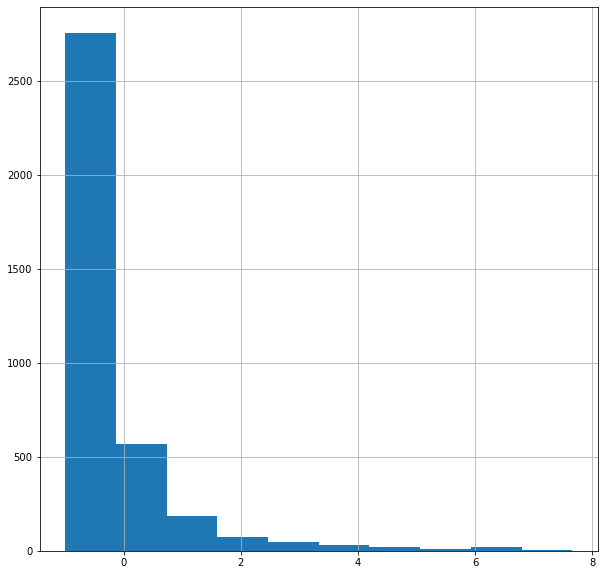

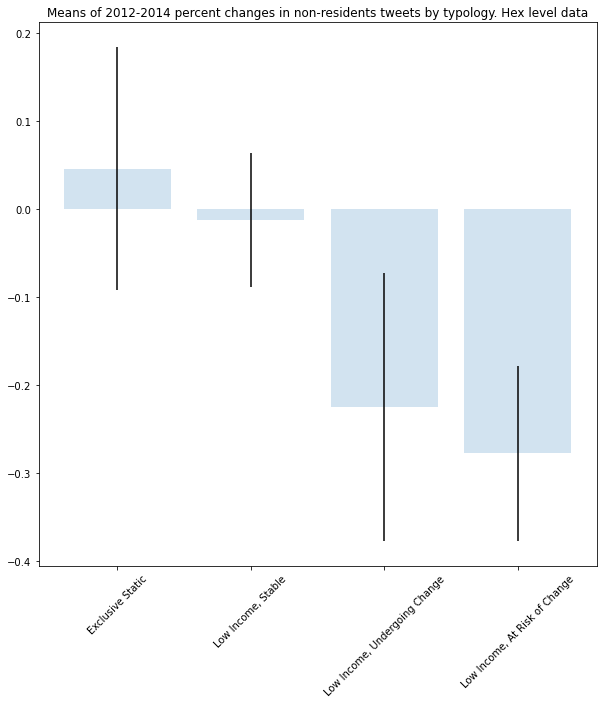

In [71]:
gdfchangesb=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2014,9,30), period_statistic="sum")

#1 Get centroids
gdfchanges_pointsb=myh3.df_with_hexid_to_centroids_gdf(gdfchangesb, hexcolname='_id')

# 3 Spatial Join between centroids and census track shapes
tweets_tractsb=gpd.sjoin(gdfchanges_pointsb, tracts, how="inner", op='intersects')

typo_statsb=tweets_tractsb[['nonresidents_dif','nonresidents_ch', 
                            'nonresidents_p0', 'standardized_types']
                          ].groupby('standardized_types').agg(['mean','count','sem'])

typo_statsb.reset_index(inplace=True)

tweets_tractsb.loc[tweets_tractsb.nonresidents_ch<8].nonresidents_ch.hist()

barchart(tweets_tractsb, 'nonresidents_ch', title='Means of 2012-2014 percent changes in non-residents tweets by typology. Hex level data')

## Filter totalcounts_p0 to >= 100 tweets per hex

In [72]:
tweets_tracts = tweets_tracts[tweets_tracts['totalcounts_p0']>=100]

In [73]:
typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 
                          'nonresidents_p0', 'standardized_types']
                        ].groupby('standardized_types').agg(['mean','count','sem'])

typo_stats.reset_index(inplace=True)

In [74]:
typo_stats

standardized_types nonresidents_dif                   \
                                             mean count        sem   
0               Exclusive Static        -9.295699    31  24.276284   
1  Low Income, At Risk of Change       -45.303571    49  10.289702   
2             Low Income, Stable       -38.388426   150   7.668106   
3  Low Income, Undergoing Change        15.203704    18  58.388308   
4                          Other       -25.875745   156  11.363562   

  nonresidents_ch                 nonresidents_p0                    
             mean count       sem            mean count         sem  
0       -0.323357    31  0.102342      562.581989    31  188.355778  
1       -0.422099    49  0.115498      396.070295    49   92.946905  
2       -0.463098   150  0.049195      366.417778   150   46.978990  
3       -0.262405    18  0.250529      291.650463    18   73.123083  
4       -0.423549   156  0.066523      295.353722   156   31.383111

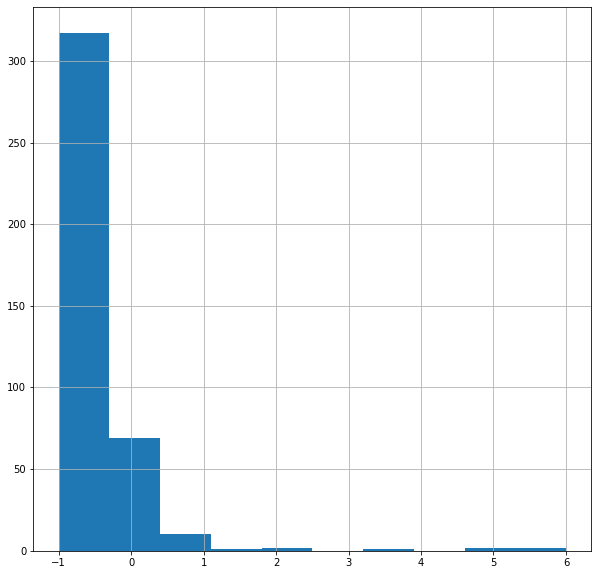

In [75]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

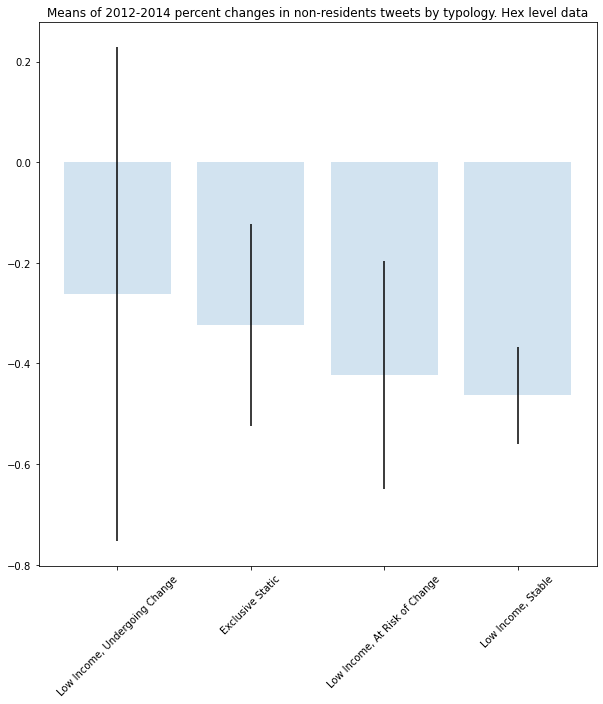

In [76]:
barchart(tweets_tracts, 'nonresidents_ch', 
         title='Means of 2012-2014 percent changes in non-residents tweets by typology. Hex level data')

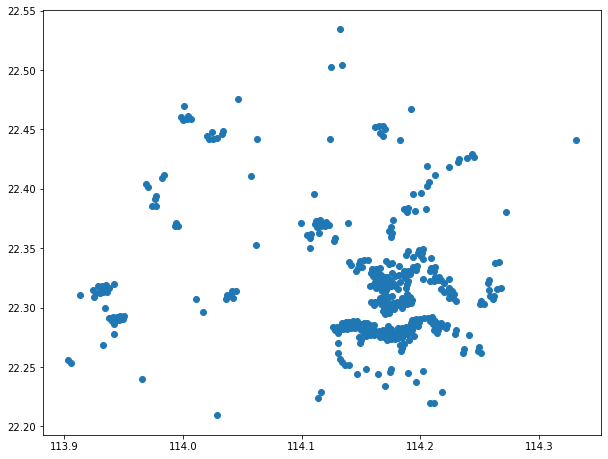

In [77]:
tweets_tracts.plot()

## Repeat analysis summing tweets in each period

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


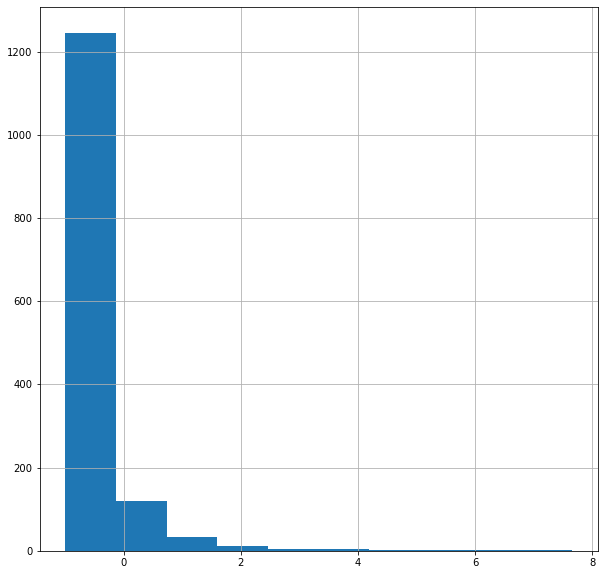

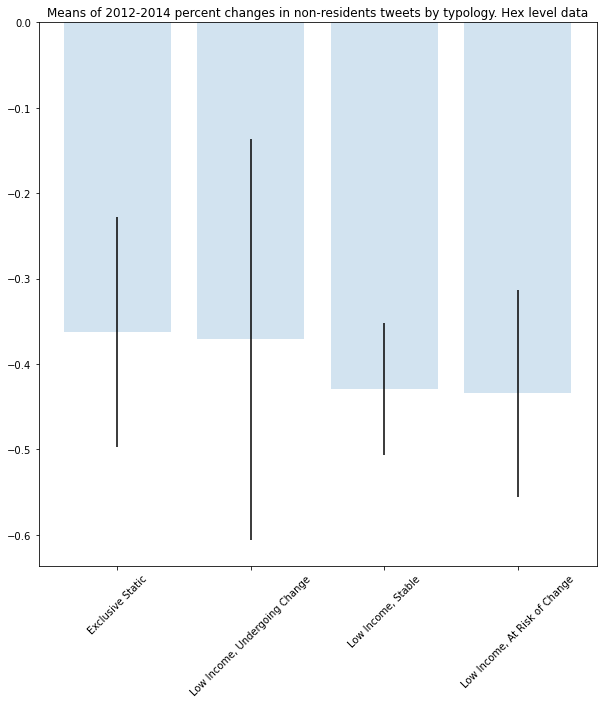

In [78]:
gdfchangesb=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2014,9,30), period_statistic="sum")

#1 Get centroids
gdfchanges_pointsb=myh3.df_with_hexid_to_centroids_gdf(gdfchangesb, hexcolname='_id')

# 3 Spatial Join between centroids and census track shapes
tweets_tractsb=gpd.sjoin(gdfchanges_pointsb, tracts, how="inner", op='intersects')

tweets_tractsb= tweets_tractsb[tweets_tractsb['totalcounts_p0']>=100]

typo_statsb=tweets_tractsb[['nonresidents_dif','nonresidents_ch', 
                            'nonresidents_p0', 'standardized_types']
                          ].groupby('standardized_types').agg(['mean','count','sem'])

typo_statsb.reset_index(inplace=True)

tweets_tractsb.loc[tweets_tractsb.nonresidents_ch<8].nonresidents_ch.hist()

barchart(tweets_tractsb, 'nonresidents_ch', title='Means of 2012-2014 percent changes in non-residents tweets by typology. Hex level data')

## Update bounding box to only include City of Sydney proper 

In [ ]:
tracts.cx[150.9:151.3, -33.7:-33.95].plot()

In [ ]:
# create bounding box for new spatial analysis 
agg_gdf_new = agg_gdf.cx[150.8:151.3, -33.70:-34]

In [ ]:
agg_gdf_p1 = agg_gdf_new[agg_gdf_new['period']==1]
agg_gdf_p0 =agg_gdf_new[agg_gdf_new['period']==0]

In [ ]:
agg_gdf_p1.plot('nonresidents')

In [ ]:
agg_gdf_p0.plot('nonresidents')